# Programación de Momentum
## Do Industries Explain Momentum? - Moskowitz and Grinblatt

In [1]:
# Importamos paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series
import statsmodels.api as sm
from scipy import stats
import heapq 

In [41]:
# Cargamos Data
date = pd.read_csv('date.csv')
indus = pd.read_csv('industries.csv')
comm = pd.read_csv('commodities.csv')

rf = pd.read_csv('rf.csv')
rmrf = pd.read_csv('rmrf.csv')
rm = np.add(rmrf, rf)

# 4 models factors
mkt = pd.read_csv('MKT.csv', header= None)
smb = pd.read_csv('smb.csv', header= None)
hml = pd.read_csv('hml.csv', header= None)
umd = pd.read_csv('umd.csv', header= None)

indus.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
0,0.53,-5.19,1.29,2.30,10.97,-0.50,8.08,1.64,7.92,0.68,...,0.83,9.22,2.06,7.66,1.91,-23.79,-2.94,1.83,0.16,5.20
1,2.71,27.03,6.53,0.54,10.01,-3.58,-2.51,4.51,5.41,7.49,...,2.17,2.02,4.40,-2.37,4.87,5.39,-0.56,-0.09,4.38,6.76
2,1.29,4.02,1.22,5.92,-0.99,0.71,-0.51,0.61,5.37,2.40,...,2.41,2.25,0.18,-5.55,0.06,-7.87,0.17,-0.58,-1.36,-3.86
3,-3.13,-3.31,1.07,-4.41,9.47,-4.66,0.12,-0.73,-4.79,0.07,...,-0.11,-2.00,-1.08,-5.03,-2.65,-15.38,-5.34,-4.13,-5.09,-8.49
4,6.28,7.29,4.41,2.60,-5.80,-0.51,1.87,5.53,5.34,3.48,...,1.63,3.77,3.64,3.81,1.59,4.67,4.04,4.32,2.29,4.00


In [47]:
# Se definen funciones

# Función -newtable- ordena el input en un dataframe.
def newtable(ave_ret):
    NT = pd.DataFrame(ave_ret)
    return NT

# Función -visualize_data- obtenida desde internet.
def visualize_data():
    #takes only data (numbers) inside the corr matrix
    data =  df_corr.values
    fig = plt.figure(figsize=(12,6))
    #1 by 1 in plot number one
    ax = fig.add_subplot(1,1,1)
    #customizing the plot showing the correlation in color
    #if theres negative correlation if stock goes up other goes down
    heatmap = ax.pcolor(data,cmap = plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0])+0.5,minor = False)
    ax.set_yticks(np.arange(data.shape[1])+0.5,minor = False)
    #errases any gaps from the graph
    ax.invert_yaxis()
    #moves ticks from xaxis to the top
    ax.xaxis.tick_top()
    column_labels = df_corr.columns
    row_labels = df_corr.index
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    #limit of the color limit of the heatmap of correlationmatrix
    heatmap.set_clim(-1,1)
    plt.tight_layout()
    plt.show()


# Función -indicators- entrega indicadores de evaluación para una estrategia con "lookback" dias de estudio.
def indicators(data, rm, rf, lookback):
    # Time series average return
    average = data[2].mean()
    # Standard deviation momentum strategy
    deviation = data[2].std()
    # Sharpe Ratio
    sharpe_ratio = float((average - np.mean(rf[lookback:]))/deviation)

    # t-statistic
    reg = pd.DataFrame()
    reg['Returns'] = data[2]
    reg['MKT'] = rm

    monthly_ret = pd.concat([reg['Returns'], reg['MKT']], axis=1)
    y = monthly_ret['Returns']
    X = monthly_ret['MKT']
    X1 = sm.add_constant(X)
    model = sm.OLS(y, X1)
    results = model.fit()
    beta, intercept, r_value, p_value, std_err = stats.linregress(X, y)
    ######
    at_res = ['Strategy Outputs']
    at_res_col = ['Average Returns %','Std Dev %','Sharpe Ratio','Beta']
    test_df = pd.DataFrame(0, index=at_res_col, columns=at_res)
    
    test_df.iloc[0,:] = average
    test_df.iloc[1,:] = deviation
    test_df.iloc[2,:] = sharpe_ratio
    test_df.iloc[3,:] = beta

    return test_df

    

In [23]:
# 1-month, 1-month Strategy
def oneMonth_oneMonth(indus):
    output = []
    for i in range(0,len(indus)-1):
        lookback = indus[i:i+1]
        a = lookback.dropna() + 1
        ret = np.prod(a) - 1
        mom = ret.reset_index()

        top3 = sorted(zip(mom[0], mom['index']), reverse=True)[:3]
        low3 = sorted(zip(mom[0], mom['index']), reverse=True)[len(mom)-3:]
        win_lookback = newtable(top3)[1].tolist()
        loss_lookback = newtable(low3)[1].tolist()

        hold = indus[i+1:i+2]
        win_hold = hold[win_lookback].T.mean().tolist()
        loss_hold = hold[loss_lookback].T.mean().tolist()
        spread = np.subtract(win_hold, loss_hold).tolist()
    
        results = win_hold + loss_hold + spread
    
        output.append(results)
    return newtable(output)

In [25]:
# Results
oneMonth = oneMonth_oneMonth(indus)
indicators(oneMonth, rm, rf, 1)

,Strategy Outputs
Average Returns %,0.748798
Std Dev %,5.442807
Sharpe Ratio,0.084174
Beta,0.050840


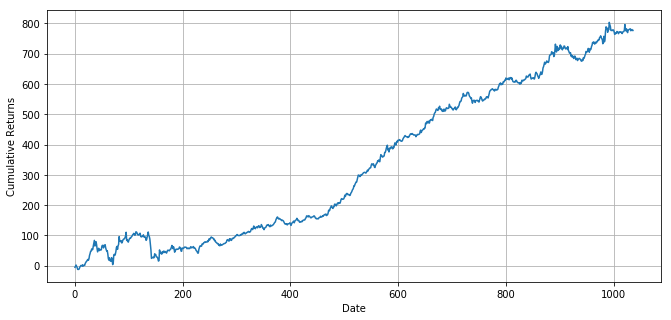

In [72]:
strategy1 = oneMonth[2].cumsum()
strategy1.plot(figsize=(11,5))
#plt.suptitle('1Month, 1Month Momentum Strategy', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

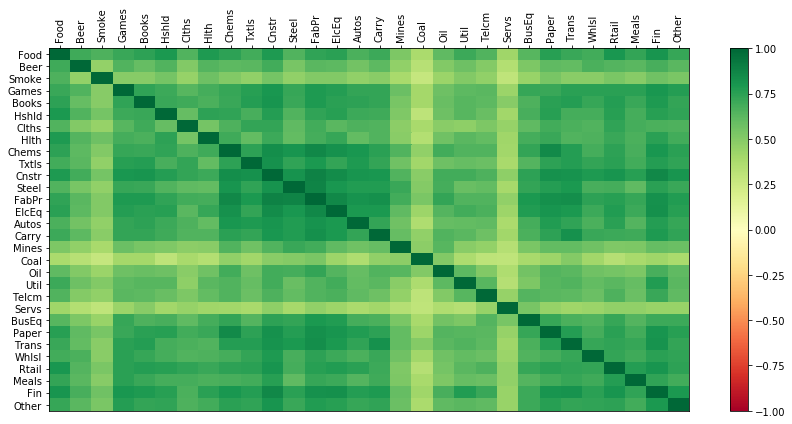

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Food,1.000000,0.698630,0.661539,0.711751,0.742939,0.795626,0.650815,0.783680,0.746513,0.691102,...,0.649198,0.419863,0.636384,0.763279,0.714023,0.692309,0.802957,0.732582,0.811871,0.725584
Beer,0.698630,1.000000,0.455186,0.651725,0.597508,0.653132,0.511926,0.642513,0.619392,0.627344,...,0.507239,0.345703,0.529924,0.616076,0.607217,0.666559,0.644357,0.631175,0.673850,0.626240
Smoke,0.661539,0.455186,1.000000,0.499875,0.495183,0.549218,0.446266,0.574304,0.511511,0.462818,...,0.461475,0.298348,0.442852,0.541732,0.491157,0.491132,0.533046,0.497226,0.564280,0.535535
Games,0.711751,0.651725,0.499875,1.000000,0.738479,0.710368,0.634579,0.679824,0.724640,0.758102,...,0.627881,0.435581,0.723421,0.712310,0.752769,0.755313,0.755396,0.750743,0.801962,0.766648
Books,0.742939,0.597508,0.495183,0.738479,1.000000,0.716286,0.699074,0.664915,0.714737,0.771085,...,0.622535,0.494440,0.661104,0.756306,0.767442,0.721888,0.768678,0.712430,0.785720,0.733233


In [48]:
# Matrix de correlacion entre las 30 industrias
df_corr = indus.corr()

visualize_data()
df_corr.head()

In [32]:
# Pregunta c)
def lookbackMonth_oneMonth(indus, lookback):
    output = []    
    #lookback = 6
    gross_indus = indus + 1
    train = gross_indus.rolling(window = lookback).apply(np.prod)
    
    ret = train - 1
    mom = ret.T.reset_index()

    for i in range(lookback-1,len(indus)-1):
        top3 = sorted(zip(mom[i], mom['index']), reverse=True)[:3]
        low3 = sorted(zip(mom[i], mom['index']), reverse=True)[len(mom)-3:]
        win_lookback = newtable(top3)[1].tolist()
        loss_lookback = newtable(low3)[1].tolist()
        win_hold = indus[win_lookback].iloc[i+1]
        EW_win = np.mean(win_hold)
        loss_hold = indus[loss_lookback].iloc[i+1]
        EW_loss = np.mean(loss_hold)
    
        spread = EW_win - EW_loss
        results = [EW_win, EW_loss, spread]
        
        output.append(results)
        
    return (newtable(output))

In [8]:
sixMonth_oneMonth = lookbackMonth_oneMonth(indus, 6)
indicators(sixMonth_oneMonth, rm, rf, 6)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


,Strategy Outputs
Average Returns %,0.032326
Std Dev %,4.342788
Sharpe Ratio,-0.059499
Beta,-0.032985


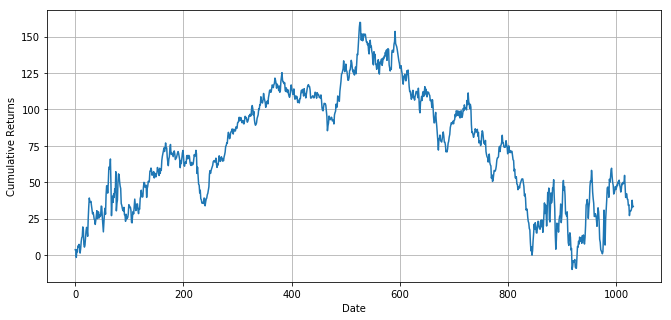

In [73]:
strategy2 = sixMonth_oneMonth[2].cumsum()
strategy2.plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

In [9]:
prueba = lookbackMonth_oneMonth(indus, 1)
indicators(prueba, rm, rf, 1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


,Strategy Outputs
Average Returns %,0.748798
Std Dev %,5.442807
Sharpe Ratio,0.084174
Beta,0.050840


In [10]:
def sixMonth_sixMonth(indus):
    output = []
    z  = 0
    for i in range(1,173):
        lookback = indus[z*6:(z+1)*6]
        a = lookback + 1
        ret = np.prod(a) - 1
        mom = ret.reset_index()

        top3 = sorted(zip(mom[0], mom['index']), reverse=True)[:3]
        low3 = sorted(zip(mom[0], mom['index']), reverse=True)[len(mom)-3:]
        win_lookback = newtable(top3)[1].tolist()
        loss_lookback = newtable(low3)[1].tolist()
    
        z = z + 1
    
        hold = indus[z*6:(z+1)*6]
        win_hold = hold[win_lookback].sum().tolist()
        loss_hold = hold[loss_lookback].sum().tolist()
        EW_win = np.mean(win_hold)
        EW_loss = np.mean(loss_hold)
        spread = EW_win - EW_loss
        results = [EW_win, EW_loss, spread]
        output.append(results)
    return newtable(output)    
    
    

In [75]:
sixMonth_strategy = sixMonth_sixMonth(indus)
indicators(sixMonth_strategy, rm, rf, 6)

,Strategy Outputs
Average Returns %,1.785484
Std Dev %,11.960202
Sharpe Ratio,0.124978
Beta,0.037873


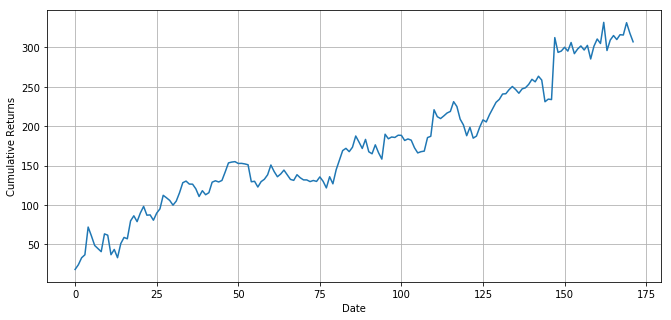

In [74]:
strategy3 = sixMonth_strategy[2].cumsum()
strategy3.plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

In [12]:
############################################
# 6 months, 6months Strategy Regressions
############################################

# 3 factors model regression
def sixsix_3factors(data, mkt, smb, hml):
    MKT = mkt[0]
    SMB = smb[0]
    HML = hml[0]

    MKT_new = []
    for i in range(1,173):
        vector = MKT[i*6]
        MKT_new.append(vector)

    SMB_new = []
    for i in range(1,173):
        vector = SMB[i*6]
        SMB_new.append(vector)
    
    HML_new = []
    for i in range(1,173):
        vector = HML[i*6]
        HML_new.append(vector)

    factors = pd.DataFrame()
    factors['MKT'] = MKT_new
    factors['SMB'] = SMB_new
    factors['HML'] = HML_new

    # 4 Factors Model Regresion
    y = data[2]
    X = factors
    X1 = sm.add_constant(X)
    model = sm.OLS(y, X1)
    results = model.fit()
    #print(results.summary())
    coef = results.params.tolist()
    coef.append(results.rsquared_adj)
    
    at_res = ['Coeficientes']
    at_res_col = ['Intercepto','MKT','SMB','HML', 'Adj R-sq']
    coef_df = pd.DataFrame(0, index=at_res_col, columns=at_res)
    
    coef_df.iloc[0,:] = coef[0]
    coef_df.iloc[1,:] = coef[1]
    coef_df.iloc[2,:] = coef[2]
    coef_df.iloc[3,:] = coef[3]
    coef_df.iloc[4,:] = coef[4]
    
    return coef_df


# 4 factors model regression
def sixsix_4factors(data, mkt, smb, hml, umd):
    MKT = mkt[0]
    SMB = smb[0]
    HML = hml[0]
    UMD = umd[0]

    MKT_new = []
    for i in range(1,173):
        vector = MKT[i*6]
        MKT_new.append(vector)

    SMB_new = []
    for i in range(1,173):
        vector = SMB[i*6]
        SMB_new.append(vector)
    
    HML_new = []
    for i in range(1,173):
        vector = HML[i*6]
        HML_new.append(vector)
        
    UMD_new = []
    for i in range(1,173):
        vector = UMD[i*6]
        UMD_new.append(vector)

    factors = pd.DataFrame()
    factors['MKT'] = MKT_new
    factors['SMB'] = SMB_new
    factors['HML'] = HML_new
    factors['UMD'] = UMD_new

    # 4 Factors Model Regresion
    y = data[2]
    X = factors
    X1 = sm.add_constant(X)
    model = sm.OLS(y, X1)
    results = model.fit()
    #print(results.summary())
    coef = results.params.tolist()
    coef.append(results.rsquared_adj)
    
    at_res = ['Coeficientes']
    at_res_col = ['Intercepto','MKT','SMB','HML','UMD', 'Adj R-sq']
    coef_df = pd.DataFrame(0, index=at_res_col, columns=at_res)
    
    coef_df.iloc[0,:] = coef[0]
    coef_df.iloc[1,:] = coef[1]
    coef_df.iloc[2,:] = coef[2]
    coef_df.iloc[3,:] = coef[3]
    coef_df.iloc[4,:] = coef[4]
    coef_df.iloc[5,:] = coef[5]
    
    
    return coef_df


############################################
# 6 months, 1month Strategy Regressions
############################################

# 3 factors model regression
def sixone_3factors(data, mkt, smb, hml):
    MKT = mkt[0]
    SMB = smb[0]
    HML = hml[0]

    factors = pd.DataFrame()
    factors['MKT'] = MKT[6:].tolist()
    factors['SMB'] = SMB[6:].tolist()
    factors['HML'] = HML[6:].tolist()

    # 4 Factors Model Regresion
    y = data[2]
    X = factors
    X1 = sm.add_constant(X)
    model = sm.OLS(y, X1)
    results = model.fit()
    #print(results.summary())
    coef = results.params.tolist()
    coef.append(results.rsquared_adj)
    
    at_res = ['Coeficientes']
    at_res_col = ['Intercepto','MKT','SMB','HML','Adj R-sq']
    coef_df = pd.DataFrame(0, index=at_res_col, columns=at_res)
    
    coef_df.iloc[0,:] = coef[0]
    coef_df.iloc[1,:] = coef[1]
    coef_df.iloc[2,:] = coef[2]
    coef_df.iloc[3,:] = coef[3]
    coef_df.iloc[4,:] = coef[4]
    
    
    return coef_df


# 4 factors model regression
def sixone_4factors(data, mkt, smb, hml, umd):
    MKT = mkt[0]
    SMB = smb[0]
    HML = hml[0]
    UMD = umd[0]

    factors = pd.DataFrame()
    factors['MKT'] = MKT[6:].tolist()
    factors['SMB'] = SMB[6:].tolist()
    factors['HML'] = HML[6:].tolist()
    factors['UMD'] = UMD[6:].tolist()

    # 4 Factors Model Regresion
    y = data[2]
    X = factors
    X1 = sm.add_constant(X)
    model = sm.OLS(y, X1)
    results = model.fit()
    #print(results.summary())
    coef = results.params.tolist()
    coef.append(results.rsquared_adj)
    
    at_res = ['Coeficientes']
    at_res_col = ['Intercepto','MKT','SMB','HML','UMD', 'Adj R-sq']
    coef_df = pd.DataFrame(0, index=at_res_col, columns=at_res)
    
    coef_df.iloc[0,:] = coef[0]
    coef_df.iloc[1,:] = coef[1]
    coef_df.iloc[2,:] = coef[2]
    coef_df.iloc[3,:] = coef[3]
    coef_df.iloc[4,:] = coef[4]
    coef_df.iloc[5,:] = coef[5]
    
    return coef_df


############################################
# 1month, 1month Strategy Regressions
############################################

# 3 factors model regression
def oneone_3factors(data, mkt, smb, hml):
    MKT = mkt[0]
    SMB = smb[0]
    HML = hml[0]

    factors = pd.DataFrame()
    factors['MKT'] = MKT[1:].tolist()
    factors['SMB'] = SMB[1:].tolist()
    factors['HML'] = HML[1:].tolist()

    # 4 Factors Model Regresion
    y = data[2]
    X = factors
    X1 = sm.add_constant(X)
    model = sm.OLS(y, X1)
    results = model.fit()
    #print(results.summary())
    coef = results.params.tolist()
    coef.append(results.rsquared_adj)
    
    at_res = ['Coeficientes']
    at_res_col = ['Intercepto','MKT','SMB','HML','Adj R-sq']
    coef_df = pd.DataFrame(0, index=at_res_col, columns=at_res)
    
    coef_df.iloc[0,:] = coef[0]
    coef_df.iloc[1,:] = coef[1]
    coef_df.iloc[2,:] = coef[2]
    coef_df.iloc[3,:] = coef[3]
    coef_df.iloc[4,:] = coef[4]
    
    return coef_df

# 4 factors model regression
def oneone_4factors(data, mkt, smb, hml, umd):
    MKT = mkt[0]
    SMB = smb[0]
    HML = hml[0]
    UMD = umd[0]

    factors = pd.DataFrame()
    factors['MKT'] = MKT[1:].tolist()
    factors['SMB'] = SMB[1:].tolist()
    factors['HML'] = HML[1:].tolist()
    factors['UMD'] = UMD[1:].tolist()
    
    # 4 Factors Model Regresion
    y = data[2]
    X = factors
    X1 = sm.add_constant(X)
    model = sm.OLS(y, X1)
    results = model.fit()
    #print(results.summary())
    coef = results.params.tolist()
    coef.append(results.rsquared_adj)
    
    at_res = ['Coeficientes']
    at_res_col = ['Intercepto','MKT','SMB','HML','UMD', 'Adj R-sq']
    coef_df = pd.DataFrame(0, index=at_res_col, columns=at_res)
    
    coef_df.iloc[0,:] = coef[0]
    coef_df.iloc[1,:] = coef[1]
    coef_df.iloc[2,:] = coef[2]
    coef_df.iloc[3,:] = coef[3]
    coef_df.iloc[4,:] = coef[4]
    coef_df.iloc[5,:] = coef[5]
    
    return coef_df

In [78]:
# 6Months, 6Months regressions
reg_4f_6m6m = sixsix_4factors(xoxo, mkt, smb, hml, umd)
reg_3f_6m6m = sixsix_3factors(xoxo, mkt, smb, hml)

In [81]:
# 6Months, 1Month regressions
reg_4f_6m1m = sixone_4factors(sixMonth_oneMonth, mkt, smb, hml, umd)
reg_3f_6m1m = sixone_3factors(sixMonth_oneMonth, mkt, smb, hml)

In [83]:
# 1Month, 1Month regressions
reg_4f_1m1m = oneone_4factors(prueba, mkt, smb, hml, umd)
reg_3f_1m1m = oneone_3factors(prueba, mkt, smb, hml)
reg_3f_1m1m

,Coeficientes
Intercepto,0.721948
MKT,-0.043732
SMB,-0.080839
HML,0.188187
Adj R-sq,0.014346


In [20]:
################################
######### COMMODITIES ##########
################################
# Visualizamos data
comm.head()

,ALUMINUM,BRENTOIL,CATTLE,COCOA,COFFEE,COPPER,CORN,COTTON,CRUDE,FEEDERCATTLE,...,RUBBER,SILVER,SOYBEANS,SOYMEAL,SOYOIL,SUGAR,TIN,UNLEADED,WHEAT,ZINC
0,NaN,NaN,0.02,-0.21,NaN,NaN,0.01,NaN,NaN,NaN,...,NaN,-0.01,-0.01,NaN,NaN,0.01,NaN,NaN,-0.01,NaN
1,NaN,NaN,0.02,-0.11,NaN,NaN,0.02,NaN,NaN,NaN,...,NaN,-0.01,-0.02,NaN,NaN,0.03,NaN,NaN,-0.02,NaN
2,NaN,NaN,0.06,0.02,NaN,NaN,0.00,NaN,NaN,NaN,...,NaN,0.00,-0.05,NaN,NaN,-0.04,NaN,NaN,-0.01,NaN
3,NaN,NaN,0.07,-0.14,NaN,NaN,-0.02,NaN,NaN,NaN,...,NaN,-0.01,-0.03,NaN,NaN,-0.19,NaN,NaN,0.00,NaN
4,NaN,NaN,-0.02,-0.13,NaN,NaN,0.00,NaN,NaN,NaN,...,NaN,-0.01,0.03,NaN,NaN,-0.09,NaN,NaN,0.01,NaN


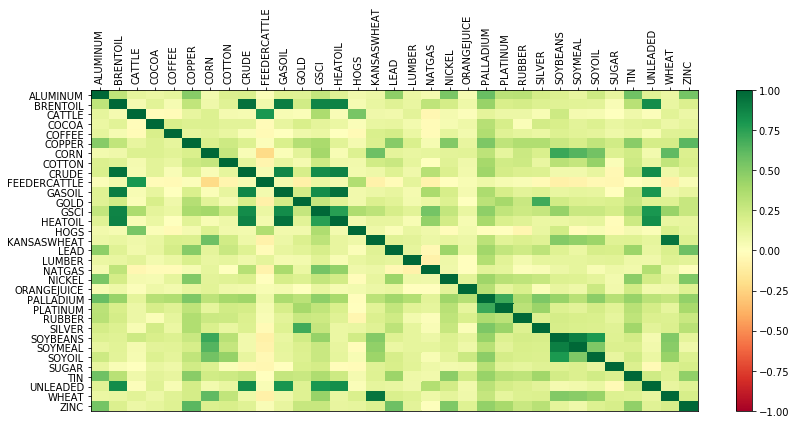

In [49]:
# Matrix de Correlación para commodities
df_corr = comm.corr()
visualize_data()

In [85]:
# Aplicamos funciones de estrategias de momentum construidas
# 1Month, 1Month Strategy
comm_1M1M = oneMonth_oneMonth(comm)
indicators(x, rm, rf, 1)

,Strategy Outputs
Average Returns %,0.001100
Std Dev %,0.079105
Sharpe Ratio,-3.660410
Beta,0.000274


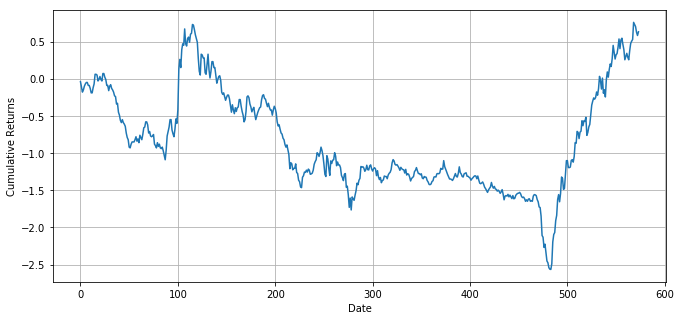

In [86]:
strategy4 = comm_1M1M[2].cumsum()
strategy4.plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

In [88]:
# 6Months, 1Month Strategy
comm_6M1M = lookbackMonth_oneMonth(comm, 6)
indicators(y, rm, rf, 6)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


,Strategy Outputs
Average Returns %,0.009704
Std Dev %,0.104781
Sharpe Ratio,-2.681919
Beta,NaN


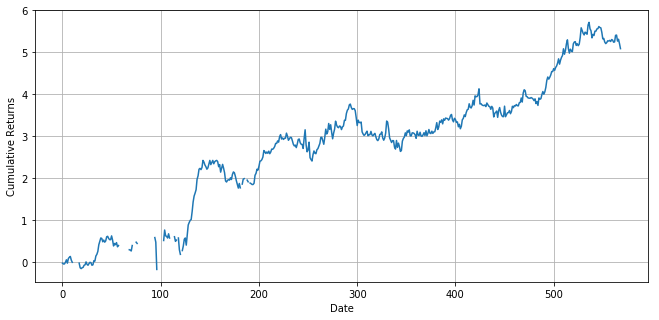

In [89]:
strategy5 = comm_6M1M[2].cumsum()
strategy5.plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

In [104]:
# 6Months, 6Months Strategy
comm_6M6M = sixMonth_sixMonth(comm)
indicators(comm_6M6M[:94], rm, rf, 6)


,Strategy Outputs
Average Returns %,0.041028
Std Dev %,0.238843
Sharpe Ratio,-1.045410
Beta,-0.000647


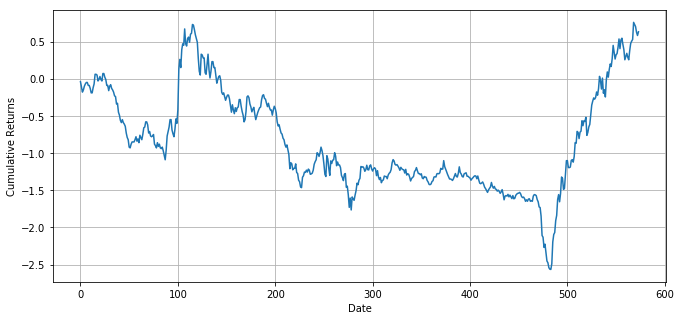

In [97]:
strategy6 = x[2].cumsum()
strategy6.plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()